# Atmosfer pressure. Construction of a regression model.

<a name="1common."></a>
## <a name="0.0"></a>Contents:
* [Library loading and self-written functions](#0.)
* [Data loading](#1.)
* [Part 1.Research data analysis](#8.)
* [Electrode data](#2.)
* [Data on the supply of bulk materials (volume, time of submission)](#3.)
* [Data on gas purging of the alloy](#4.)
* [Data on wire materials (volume, time)] (#5.)
* [Temperature measurement results](#6.)
* [List of clarifying questions and an approximate plan for solving the problem.](#7.)
* [Part 2. Solution Code](#9.)
* [Data Cleaning](#10.)
* [Preparing data for the model](#11.)
* [Building the model](#12.)
* [Testing the model](#13.)
* [Checking the model for adequacy](#14.)
* [Output](#15.)

### Description of data

The system of automatic state ambient air monitoring stations in Lithuania consists of 14 urban air quality monitoring stations operating in Vilnius, Kaunas, Klaipėda, Šiauliai, Panevėžys, Jonava, Kėdainiai, Naujoji Akmenė and Mažeikiai and 3 integrated monitoring stations operating in Aukštaitija, Žemaitija and Dzūkija National Parks.

Concentrations of the following pollutants are measured at automatic air quality monitoring stations: particulate matter PM10, fine particulate matter PM2.5, nitrogen oxides (NO2, NOx, NO), sulfur dioxide (SO2), carbon monoxide (CO), ozone (O3), benzene, mercury.
The tests and measurements shall be carried out in accordance with the requirements of Directives 2004/107/EC of the European Parliament and of the Council relating to arsenic, cadmium, mercury, nickel and polycyclic aromatic hydrocarbons in ambient air and 2008/50/EC on ambient air quality and cleaner air for Europe.


The data consists of files obtained from different sources:

Averages.csv
Quantity.csv
QuantityUnits.csv
Station.csv

https://data.gov.lt/datasets/500/

## Подгрузка библиотек и самописные функции
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [180]:
import pandas as pd
import numpy as np
import time

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError

from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
#from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)
#from pandas.core.common import SettingWithCopyWarning

%config InlineBackend.figure_format='retina'
#arnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#warnings.simplefilter(action="ignore", category=UserWarning)

In [181]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from numpy import asarray

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [182]:
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

In [183]:
#**Function print_basic_info, to display information about the array and its variables.**

#* base - database name
#* info - 1: output information about the array, other: no output
#* describe - 1: output description of array variables, other: no output
#* duplicate - 1: display the number of complete duplicates
#* head - n: output example base (output n - lines), n < 1: no output

def print_basic_info(base, info, describe, duplicat, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

## Loading data
<a name="1."></a>
[<font size="2">(to contents)</font>](#1common.)

In [184]:
data_averages = pd.read_csv('datasets/Averages.csv', sep=',',decimal='.')
data_quantity = pd.read_csv('datasets/Quantity.csv', sep=',',decimal='.')
data_quantity_units = pd.read_csv('datasets/QuantityUnits.csv', sep=',',decimal='.')
data_station = pd.read_csv('datasets/Station.csv', sep=',',decimal='.')

<!-- # data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
# data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
# data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
# data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
# data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
# data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
# data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') -->

## Исследовательский анализ данных
<a name="8."></a>
[<font size="2">(к содержанию)</font>](#1common.)

### Данные об изменениях
<a name="2."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [185]:
#данные об электродах;
print_basic_info(data_averages,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627777 entries, 0 to 2627776
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   _type         object 
 1   _id           object 
 2   _revision     object 
 3   id            int64  
 4   stat_num._id  object 
 5   ldatetime     object 
 6   code_combi    int64  
 7   lvalue        float64
 8   atribut       int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 180.4+ MB
None

  head 


,_type,_id,_revision,id,stat_num._id,ldatetime,code_combi,lvalue,atribut
0,datasets/gov/aaa/oro_stociu_matavimai/Averages,ffc91117-d74c-411b-b579-6006f6343124,fe9212e8-524f-4771-884c-f37c4c520ce1,100013482,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-11T13:00:00,401,8.23,1
1,datasets/gov/aaa/oro_stociu_matavimai/Averages,7c1a9813-4831-46a5-ab6c-6dd750ecb0a3,4d74d0ae-0cf6-40bf-bee1-f2afaa5ef962,100013570,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-11T20:00:00,906,993.06,1
2,datasets/gov/aaa/oro_stociu_matavimai/Averages,8f325751-c286-44f5-a27a-e16c72b0c6fc,cb99870b-f52d-487c-ac17-32b3fbd95381,100171317,6bd59444-5437-447d-bc2d-c32ef5b0a964,2012-12-12T08:00:00,5301,-0.55,1
3,datasets/gov/aaa/oro_stociu_matavimai/Averages,0fa048e3-5004-49c8-a3f9-ffdffc57b934,e7eca78b-c7e5-4f5c-ad8f-24db108ad0c7,100185170,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-12T08:00:00,906,995.97,1
4,datasets/gov/aaa/oro_stociu_matavimai/Averages,aa414bf9-0821-4061-910b-19d4bb395009,4e1d3552-e06a-4b61-b758-15d123df2091,100353357,6bd59444-5437-447d-bc2d-c32ef5b0a964,2012-12-13T02:00:00,7001,0.00,1



  describe  


  _type  
 count                                            2627777
unique                                                 1
top       datasets/gov/aaa/oro_stociu_matavimai/Averages
freq                                             2627777
Name: _type, dtype: object

  _id  
 count                                  2627777
unique                                 2627777
top       ffc91117-d74c-411b-b579-6006f6343124
freq                                         1
Name: _id, dtype: object

  _revision  
 count                                  2627777
unique                                 2627777
top       fe9212e8-524f-4771-884c-f37c4c520ce1
freq                                         1
Name: _revision, dtype: object

  id  
 count     2627777.00
mean    351406264.52
std     206039965.19
min        722313.00
25%     125469720.00
50%     398467385.00
75%     520119327.00
max     680955116.00
Name: id, dtype: float64

  stat_num._id  
 count                                  

In [186]:
data_averages['datetime'] = pd.to_datetime(data_averages.ldatetime)

 % mean in test sample: target 2802.14


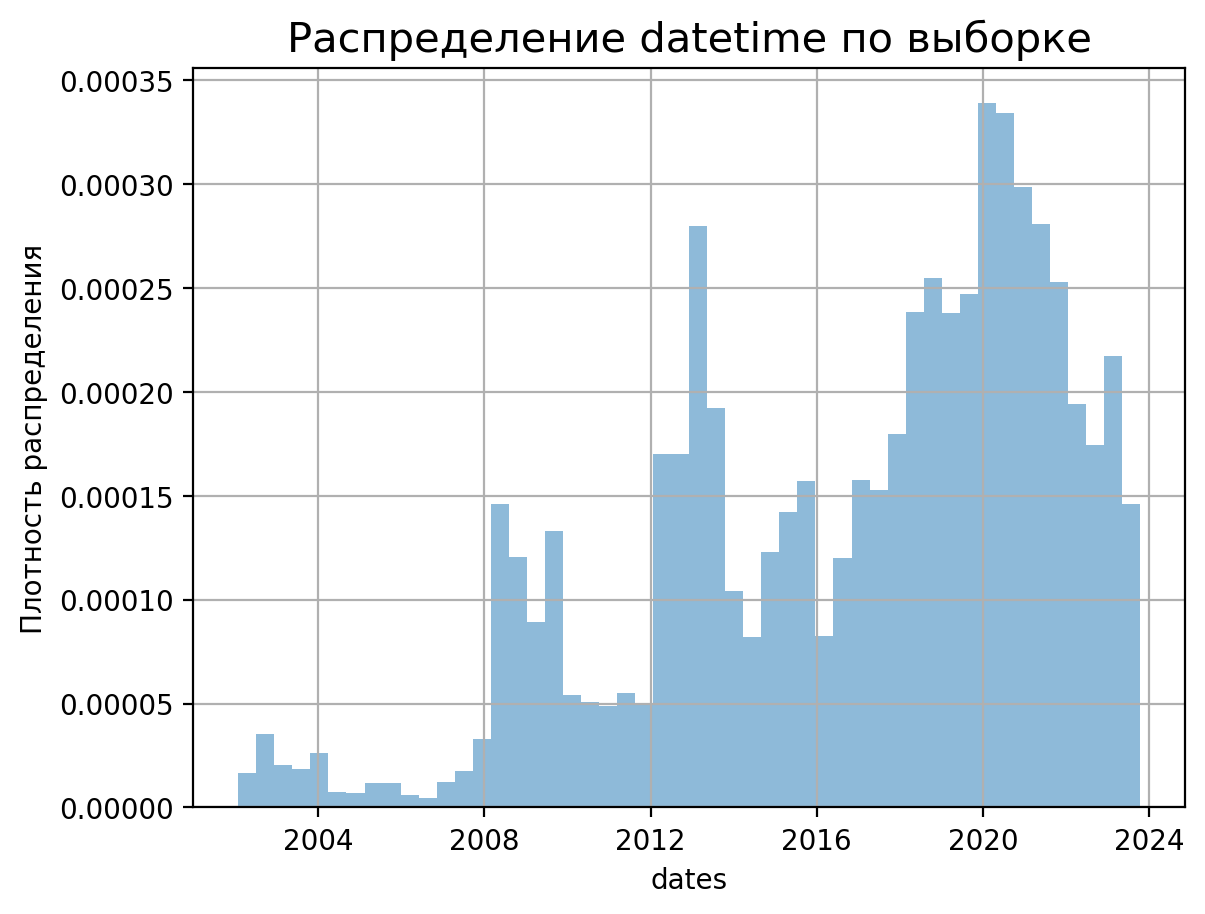

In [187]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(data_averages['code_combi'].mean(),2),'blue'))

data_averages['datetime'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('dates')
plt.ylabel('Плотность распределения')
plt.title('Распределение datetime по выборке', fontsize=15) 
plt.show()

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

In [188]:
#данные об электродах;
print_basic_info(data_quantity,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _type          90 non-null     object
 1   _id            90 non-null     object
 2   _revision      90 non-null     object
 3   code_quantity  90 non-null     int64 
 4   shortname      90 non-null     object
 5   longname       78 non-null     object
 6   attrib         90 non-null     object
 7   code_unit._id  89 non-null     object
 8   id             90 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 6.5+ KB
None

  head 


,_type,_id,_revision,code_quantity,shortname,longname,attrib,code_unit._id,id
0,datasets/gov/aaa/oro_stociu_matavimai/Quantity,0b30092e-0bac-4a8a-a21b-ea3916ae6e85,ff6ed76a-b4e1-4249-b1fe-c8f06aa47c79,1,SO2,sulphur dioxide,gasep,28f650e6-08d2-4311-98fe-55cc2aba9ff0,1
1,datasets/gov/aaa/oro_stociu_matavimai/Quantity,4d35af60-b123-4399-9dc3-bab198a51522,9bef114f-36d5-4326-ae1d-e8167190aab0,10,WV,wind velocity,meteo,0fc540c4-cae8-4557-a091-6e310dd8d095,10
2,datasets/gov/aaa/oro_stociu_matavimai/Quantity,e0323a9d-6af8-413e-88cb-360f54f4fa7f,10e0155e-5291-4280-9d9f-2e3b06bb22db,11,WD,wind direction,meteo,85e37543-6901-475a-83e1-0647bbd4b2bc,11
3,datasets/gov/aaa/oro_stociu_matavimai/Quantity,6173af32-5fc5-4aa6-8828-0fe40bd550ab,a255de45-9ed0-4906-8d5e-b37281187e22,12,O3,ozon,gasep,28f650e6-08d2-4311-98fe-55cc2aba9ff0,12
4,datasets/gov/aaa/oro_stociu_matavimai/Quantity,c382f198-f350-4379-9c27-8acd3d73a3aa,571f884c-7bb5-404f-9a29-0453257b45ce,13,CO,carbon monoxide,gasep,48518a60-6e96-4b6f-93b8-bcaeff67685a,13



  describe  


  _type  
 count                                                 90
unique                                                 1
top       datasets/gov/aaa/oro_stociu_matavimai/Quantity
freq                                                  90
Name: _type, dtype: object

  _id  
 count                                       90
unique                                      90
top       0b30092e-0bac-4a8a-a21b-ea3916ae6e85
freq                                         1
Name: _id, dtype: object

  _revision  
 count                                       90
unique                                      90
top       ff6ed76a-b4e1-4249-b1fe-c8f06aa47c79
freq                                         1
Name: _revision, dtype: object

  code_quantity  
 count        90.00
mean         45.50
std          26.12
min           1.00
25%          23.25
50%          45.50
75%          67.75
max          90.00
Name: code_quantity, dtype: float64

  shortname  
 count      90
unique     90
top     

In [189]:
data_quantity.longname.value_counts()

longname
wind direction              2
n-hexane                    2
non-methane hydrocarbons    2
sulphur dioxide             1
1,3-butadiene-PID           1
                           ..
n-heptane                   1
PM25 particulates           1
nitrogen oxides             1
wind speed                  1
PM total particulates       1
Name: count, Length: 75, dtype: int64

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

In [190]:
#данные об электродах;
print_basic_info(data_quantity_units,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   _type              962 non-null    object
 1   _id                962 non-null    object
 2   _revision          962 non-null    object
 3   code_combi         962 non-null    int64 
 4   code_quantity._id  962 non-null    object
 5   code_unit._id      962 non-null    object
dtypes: int64(1), object(5)
memory usage: 45.2+ KB
None

  head 


,_type,_id,_revision,code_combi,code_quantity._id,code_unit._id
0,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,fc3dbd53-8169-4d06-ba40-c0c246979a43,2831cd24-7b3f-464c-8059-7b33a9f822b1,119,0b30092e-0bac-4a8a-a21b-ea3916ae6e85,97bed18a-fcaa-4ecd-97a6-0b04d2801e29
1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,fe65364b-0d80-4589-a0c7-23cb3a9711c2,5859818c-a22f-4dc5-a3b6-1c166007fae2,120,0b30092e-0bac-4a8a-a21b-ea3916ae6e85,8b8b188a-4344-4c05-8fe9-39b73e8d5915
2,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,883afb01-6f6e-4157-a355-83a6a1699023,9631009a-5f10-4530-a62b-2949f6dec22e,121,0b30092e-0bac-4a8a-a21b-ea3916ae6e85,8da58da5-dedc-4c8d-b799-3714f527c322
3,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,9a02e7e2-e6d3-4ebb-91cb-126538b02bf5,93bf15cb-4a3a-46bb-b43a-8e9c01d8ffe4,201,686bb9d9-e770-4034-b6d9-f75a6d922141,28f650e6-08d2-4311-98fe-55cc2aba9ff0
4,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,6b2ea22a-79c6-4310-9ccc-925dd5385b24,6df05649-8351-4879-a00d-cdf661c9bb14,202,686bb9d9-e770-4034-b6d9-f75a6d922141,48518a60-6e96-4b6f-93b8-bcaeff67685a



  describe  


  _type  
 count                                                   962
unique                                                    1
top       datasets/gov/aaa/oro_stociu_matavimai/Quantity...
freq                                                    962
Name: _type, dtype: object

  _id  
 count                                      962
unique                                     962
top       fc3dbd53-8169-4d06-ba40-c0c246979a43
freq                                         1
Name: _id, dtype: object

  _revision  
 count                                      962
unique                                     962
top       2831cd24-7b3f-464c-8059-7b33a9f822b1
freq                                         1
Name: _revision, dtype: object

  code_combi  
 count       962.00
mean       2500.48
std        1682.71
min         101.00
25%        1210.25
50%        2319.50
75%        3507.75
max        8621.00
Name: code_combi, dtype: float64

  code_quantity._id  
 count                 

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

In [191]:
#данные об электродах;
print_basic_info(data_station,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _type      22 non-null     object 
 1   _id        22 non-null     object 
 2   _revision  22 non-null     object 
 3   stat_num   22 non-null     int64  
 4   latitude   17 non-null     float64
 5   longitude  17 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ KB
None

  head 


,_type,_id,_revision,stat_num,latitude,longitude
0,datasets/gov/aaa/oro_stociu_matavimai/Station,a23fd8f6-f238-4fa8-88d0-ddeb23b60b59,d01623db-0c92-4db2-a1d5-6b06831310df,33,55.69,21.18
1,datasets/gov/aaa/oro_stociu_matavimai/Station,8628cd14-cc2c-4b7a-a17d-98e9b9d42083,6baf2065-1a49-4f4a-a6af-32eaa52fde6c,12,55.73,24.37
2,datasets/gov/aaa/oro_stociu_matavimai/Station,27cbf611-ff8f-4851-bf66-e87d96303ad8,f7afcd74-b6b3-48d7-883c-e2abe7a46592,11,NaN,NaN
3,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
4,datasets/gov/aaa/oro_stociu_matavimai/Station,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,aa4d9094-dcb2-488d-b6b6-97c128a9a4ff,52,54.09,24.29



  describe  


  _type  
 count                                                22
unique                                                1
top       datasets/gov/aaa/oro_stociu_matavimai/Station
freq                                                 22
Name: _type, dtype: object

  _id  
 count                                       22
unique                                      22
top       a23fd8f6-f238-4fa8-88d0-ddeb23b60b59
freq                                         1
Name: _id, dtype: object

  _revision  
 count                                       22
unique                                      22
top       d01623db-0c92-4db2-a1d5-6b06831310df
freq                                         1
Name: _revision, dtype: object

  stat_num  
 count        22.00
mean         32.45
std          26.35
min           1.00
25%          11.25
50%          31.50
75%          43.75
max          99.00
Name: stat_num, dtype: float64

  latitude  
 count        17.00
mean         55.30
std          

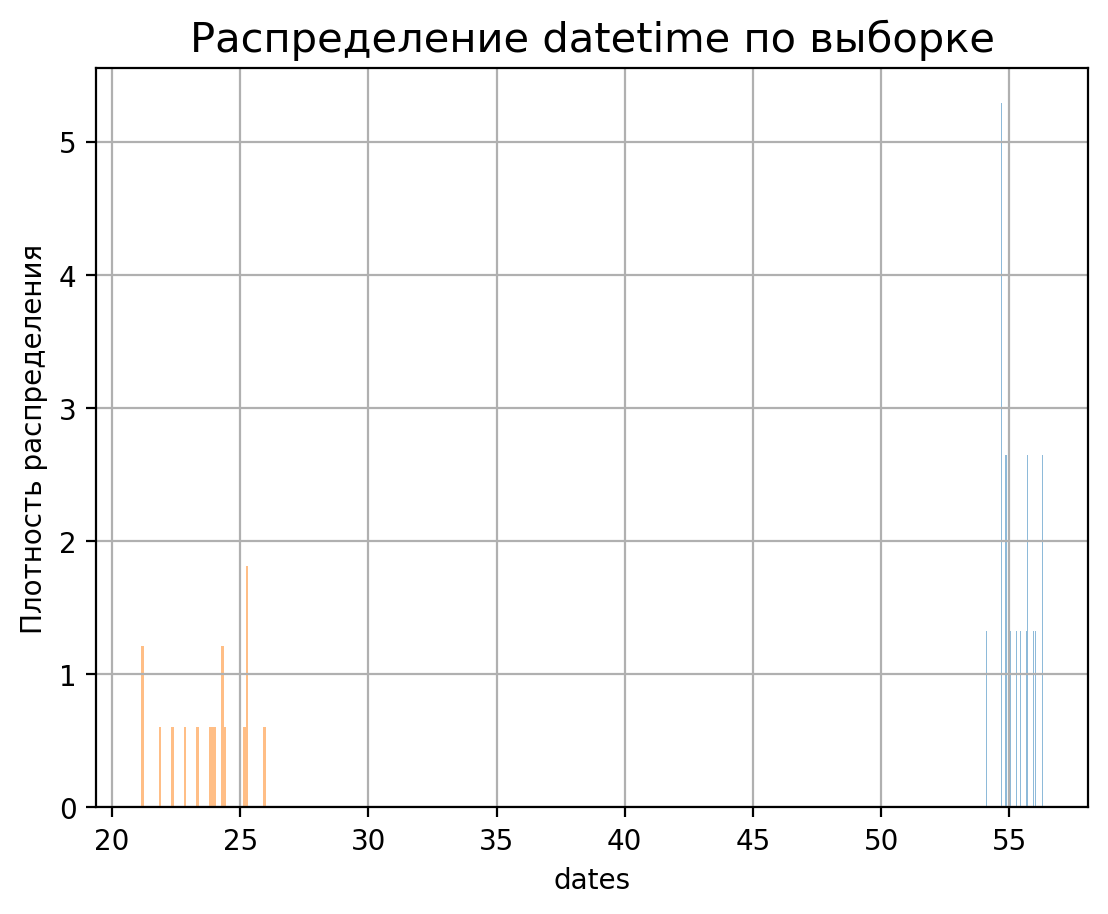

In [192]:
#**Проверка на логичность**

data_station['latitude'].hist(bins = 50, alpha=0.5, density=True)
data_station['longitude'].hist(bins = 50, alpha=0.5, density=True)


plt.xlabel('dates')
plt.ylabel('Плотность распределения')
plt.title('Распределение datetime по выборке', fontsize=15) 
plt.show()

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

## Код решения
<a name="9."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* **Почистить данные:**
    * Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
    * Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).
    
    
* **Подготовить данные для модели:**
    * Разделение дата сета на тестовый и тренинговый/валидационный.
    * Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.


* **Построить модели:**
    * Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
    * Проверить модель на адекватность.

### Чистка данных
<a name="10."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
* Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).

Сначала поймем какие кейсы мы берем в работу. Для этого необходимо найти первую и последнюю температуру и сравнить их по времени.<br>
Выкидываем если время это одинаковое (а значит был только один замер).

Больше всего влияет информация о первичной температуре, время нагрева и сила тока.
<!-- #попробуем их перемножить, чтобы сделать новую фичу
data_united['temp_power'] = data_united.start_temp * data_united.mean_active_power * data_united.mean_reactive_power -->

In [193]:
data = data_averages.merge(data_quantity_units,how='left', on = 'code_combi')

data.groupby(by="code_unit._id", dropna=False)['lvalue'].mean()

code_unit._id
0fc540c4-cae8-4557-a091-6e310dd8d095        20.08
28f650e6-08d2-4311-98fe-55cc2aba9ff0        53.63
2b1b3b00-a4d3-4ea4-9dff-92374f6fc07b        97.15
48518a60-6e96-4b6f-93b8-bcaeff67685a       231.31
67461e7c-506e-430a-8962-cd25ebed54da       948.33
7bd372b3-8736-45af-a86f-9221dc25affa       252.22
85e37543-6901-475a-83e1-0647bbd4b2bc       189.27
866e2570-2343-40fa-b0e7-999c75f9a46e        58.41
89a0ce55-265d-4266-91ea-5eb0ed25b77b       505.71
8b8b188a-4344-4c05-8fe9-39b73e8d5915       -12.38
ce869cdc-5213-4728-96ef-a3a78b62a18b       553.20
NaN                                         27.00
Name: lvalue, dtype: float64

In [194]:
data['year'] = data.datetime.dt.year
data['month'] = data.datetime.dt.month
data['weekday'] = data.datetime.dt.weekday
data['day'] = data.datetime.dt.day

In [195]:
data = data[data['year']== 2023]
data =data[data['code_unit._id'] == '67461e7c-506e-430a-8962-cd25ebed54da']

In [196]:
d_q = data_quantity[data_quantity['code_unit._id'] == '67461e7c-506e-430a-8962-cd25ebed54da'] 
data = data.merge(d_q,how='left', on = 'code_unit._id')
data_quantity['code_unit._id'].value_counts()

code_unit._id
28f650e6-08d2-4311-98fe-55cc2aba9ff0    45
2b1b3b00-a4d3-4ea4-9dff-92374f6fc07b     9
89a0ce55-265d-4266-91ea-5eb0ed25b77b     6
bb00bdc2-70d3-4b20-a584-1586c8c1d267     5
f24213b6-172a-47b8-960c-be177c547eee     4
0fc540c4-cae8-4557-a091-6e310dd8d095     3
48518a60-6e96-4b6f-93b8-bcaeff67685a     3
85e37543-6901-475a-83e1-0647bbd4b2bc     2
866e2570-2343-40fa-b0e7-999c75f9a46e     2
8b8b188a-4344-4c05-8fe9-39b73e8d5915     2
ce869cdc-5213-4728-96ef-a3a78b62a18b     2
8da58da5-dedc-4c8d-b799-3714f527c322     2
4797ee11-9fda-4178-930f-13ad3ae435a6     1
30b66260-1510-456e-9d8b-50179126b543     1
8fd74243-e9d1-430d-9ad5-5bccd2288be3     1
67461e7c-506e-430a-8962-cd25ebed54da     1
Name: count, dtype: int64

In [197]:
data_station['stat_num._id'] = data_station['_id']
data = data.merge(data_station,how='left', on = 'stat_num._id',suffixes=('_xx', '_yy'))
data

,_type_x,_id_x,_revision_x,id_x,stat_num._id,ldatetime,code_combi,lvalue,atribut,datetime,...,shortname,longname,attrib,id_y,_type_yy,_id_yy,_revision_yy,stat_num,latitude,longitude
0,datasets/gov/aaa/oro_stociu_matavimai/Averages,6081a1af-d3d7-46ff-a83e-e0da6e5191f3,02655ba4-e7ee-47d5-814d-683b1821ab15,652315134,f15078a3-c648-4ef2-93eb-9d2e473fffba,2023-01-04T21:00:00,906,984.48,1,2023-01-04 21:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f15078a3-c648-4ef2-93eb-9d2e473fffba,051fab6f-10b2-4774-b65b-fc7098ef82fe,53,56.01,21.89
1,datasets/gov/aaa/oro_stociu_matavimai/Averages,32f0fcf6-9bae-42e5-8fe7-45b69fec3115,d1f06dbf-7c48-414c-bd20-63483ec399f8,653958314,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-01-14T02:00:00,906,991.37,1,2023-01-14 02:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
2,datasets/gov/aaa/oro_stociu_matavimai/Averages,12a28f39-cd4d-4d97-8268-5a88d2b449ba,dd70eb87-4a77-4227-8d21-2532ad8a24e1,653958468,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-01-15T00:00:00,906,994.53,1,2023-01-15 00:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
3,datasets/gov/aaa/oro_stociu_matavimai/Averages,73a054c6-4d3e-482f-8597-569c4012165e,85af44b6-d331-4c2c-a668-d9f9d151e908,654441235,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,2023-01-17T20:00:00,906,984.95,1,2023-01-17 20:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,aa4d9094-dcb2-488d-b6b6-97c128a9a4ff,52,54.09,24.29
4,datasets/gov/aaa/oro_stociu_matavimai/Averages,e5143f3c-88f0-496c-92cb-d246c80e34df,bcaafd70-904f-421d-b8de-aef39f7648ba,654774141,f15078a3-c648-4ef2-93eb-9d2e473fffba,2023-01-19T06:00:00,906,980.80,1,2023-01-19 06:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f15078a3-c648-4ef2-93eb-9d2e473fffba,051fab6f-10b2-4774-b65b-fc7098ef82fe,53,56.01,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15647,datasets/gov/aaa/oro_stociu_matavimai/Averages,32a05967-e722-4a82-9036-c0dab572d66d,a7223c28-2956-4a8c-a2cb-92976c6b81bc,680802328,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T11:00:00,906,999.80,1,2023-10-10 11:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15648,datasets/gov/aaa/oro_stociu_matavimai/Averages,3de84c66-55ab-4b06-a907-db0d554b2a03,0637591a-5701-4f18-b3d7-ec928af6581f,680802335,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T12:00:00,906,1000.00,1,2023-10-10 12:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15649,datasets/gov/aaa/oro_stociu_matavimai/Averages,d85fb434-9679-4605-86c3-72e289343ce4,7c3aad47-a599-461f-82ac-fe8ba6b5cf14,680802363,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T16:00:00,906,1000.18,1,2023-10-10 16:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15650,datasets/gov/aaa/oro_stociu_matavimai/Averages,a143a44a-e64c-4ba9-8412-1d10650a8008,c088e072-c0f6-45ef-ae84-07e8d4c2d896,680802370,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T17:00:00,906,1000.02,1,2023-10-10 17:00:00,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00


 % mean in test sample: target 953.93


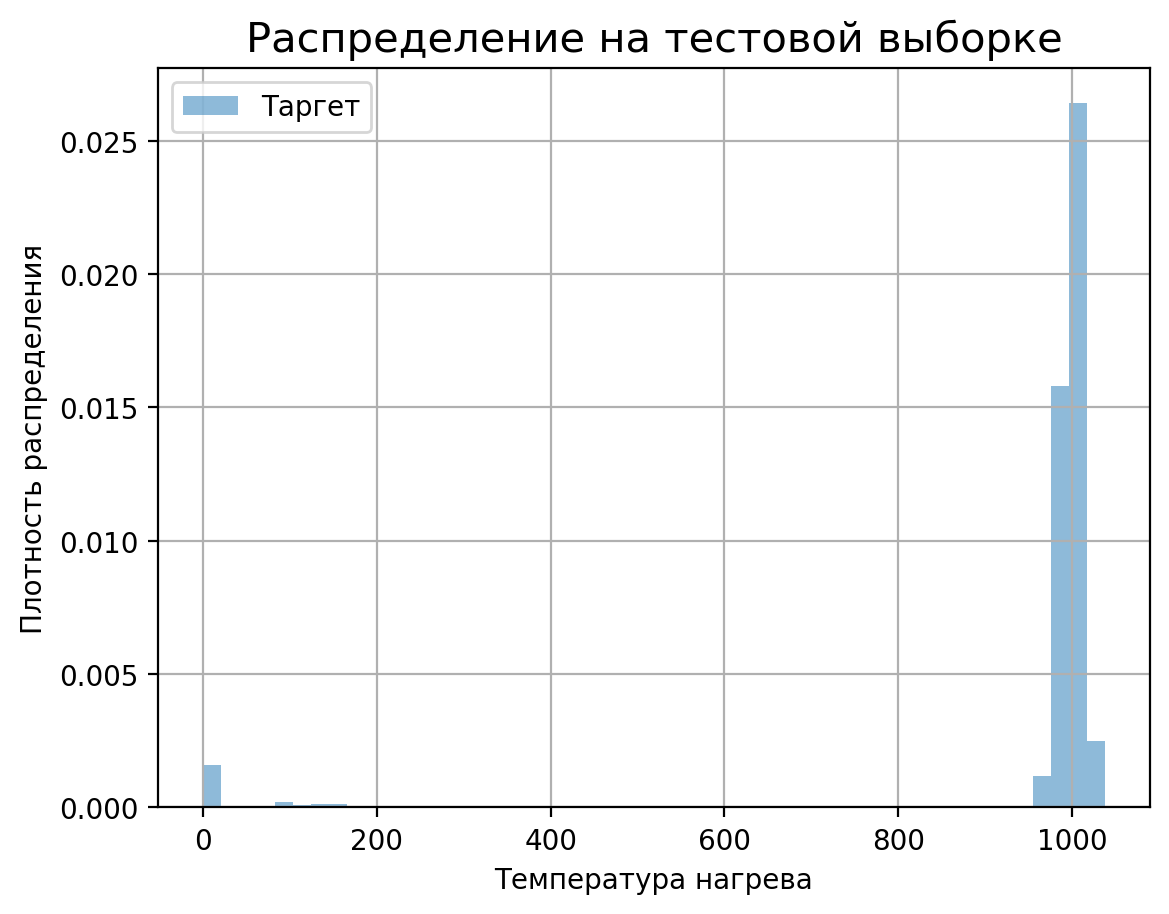

In [198]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(data['lvalue'].mean(),2),'blue'))

data['lvalue'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

In [199]:
data['lvalue'].quantile(0.05)

968.391015625015

In [200]:
data['lvalue'].quantile(0.95)

1017.1744873047201

In [201]:
data = data[data['lvalue'] > 968]
#data = data[data['lvalue'] < 1017]

 % mean in test sample: target 999.46


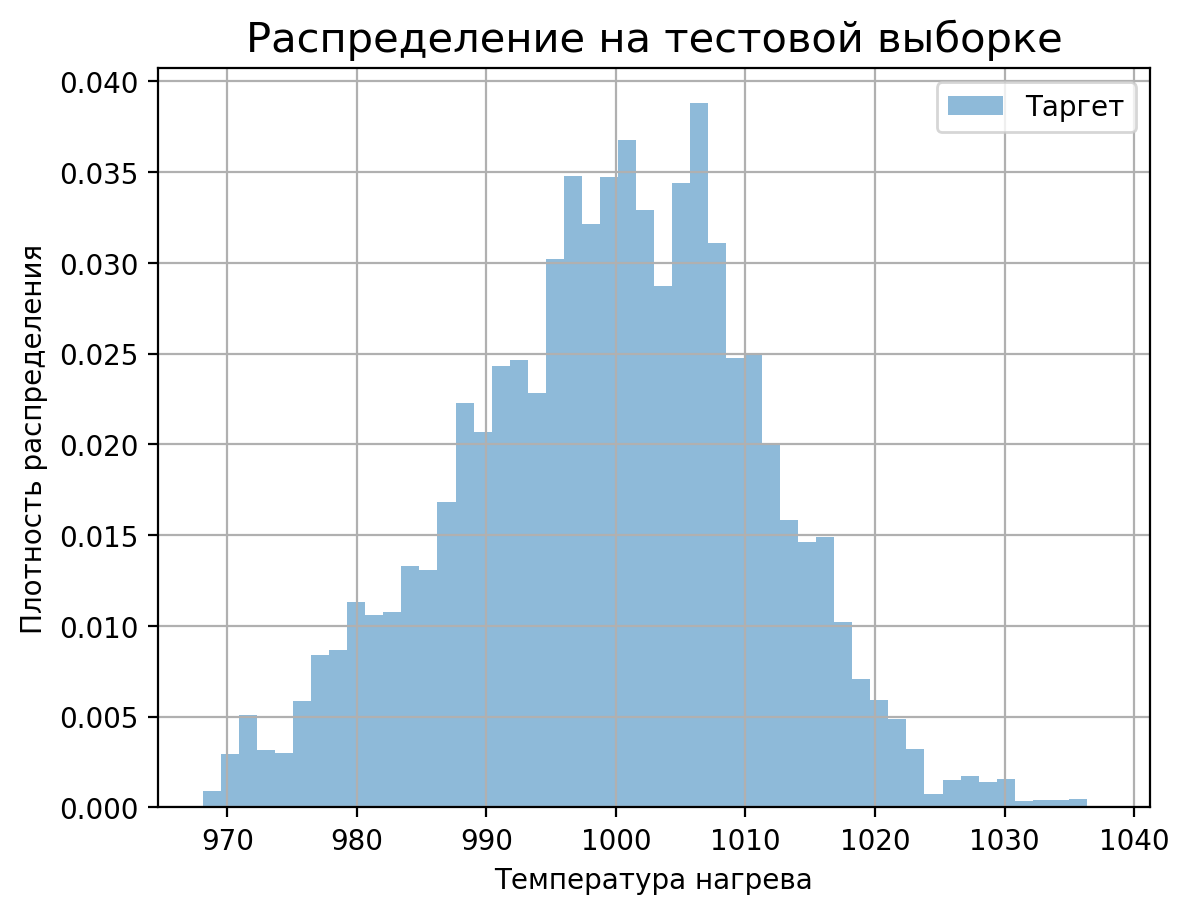

In [202]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(data['lvalue'].mean(),2),'blue'))

data['lvalue'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет'])
plt.show()

In [203]:
#data = data[['lvalue','stat_num','code_quantity._id','year','month','weekday','day','latitude','longitude']]
data = data[['lvalue','stat_num','year','month','weekday','day','latitude','longitude']]

In [204]:
data[['lvalue','stat_num','year','month','weekday','day','latitude','longitude']].corr()

,lvalue,stat_num,year,month,weekday,day,latitude,longitude
lvalue,1.00,-0.02,NaN,0.08,-0.03,-0.09,-0.42,0.04
stat_num,-0.02,1.00,NaN,-0.09,-0.01,0.02,0.07,-0.20
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.08,-0.09,NaN,1.00,-0.04,-0.05,-0.10,0.18
weekday,-0.03,-0.01,NaN,-0.04,1.00,-0.02,-0.00,0.00
day,-0.09,0.02,NaN,-0.05,-0.02,1.00,-0.02,-0.01
latitude,-0.42,0.07,NaN,-0.10,-0.00,-0.02,1.00,-0.30
longitude,0.04,-0.20,NaN,0.18,0.00,-0.01,-0.30,1.00


In [205]:
data['stat_num'] = data.stat_num.astype('str')

In [206]:
print_basic_info(data,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
Index: 14874 entries, 0 to 15651
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lvalue     14874 non-null  float64
 1   stat_num   14874 non-null  object 
 2   year       14874 non-null  int32  
 3   month      14874 non-null  int32  
 4   weekday    14874 non-null  int32  
 5   day        14874 non-null  int32  
 6   latitude   14854 non-null  float64
 7   longitude  14854 non-null  float64
dtypes: float64(3), int32(4), object(1)
memory usage: 813.4+ KB
None

  head 


,lvalue,stat_num,year,month,weekday,day,latitude,longitude
0,984.48,53,2023,1,2,4,56.01,21.89
1,991.37,51,2023,1,5,14,55.46,26.00
2,994.53,51,2023,1,6,15,55.46,26.00
3,984.95,52,2023,1,1,17,54.09,24.29
4,980.80,53,2023,1,3,19,56.01,21.89



  describe  


  lvalue  
 count     14874.00
mean        999.46
std          11.58
min         968.13
25%         991.70
50%        1000.09
75%        1007.37
max        1037.74
Name: lvalue, dtype: float64

  stat_num  
 count     14874
unique       18
top          52
freq       5319
Name: stat_num, dtype: object

  year  
 count     14874.00
mean       2023.00
std           0.00
min        2023.00
25%        2023.00
50%        2023.00
75%        2023.00
max        2023.00
Name: year, dtype: float64

  month  
 count     14874.00
mean          4.51
std           2.62
min           1.00
25%           2.00
50%           4.00
75%           7.00
max          10.00
Name: month, dtype: float64

  weekday  
 count     14874.00
mean          2.87
std           2.02
min           0.00
25%           1.00
50%           3.00
75%           5.00
max           6.00
Name: weekday, dtype: float64

  day  
 count     14874.00
mean         15.04
std           8.45
min           1.00
25%           8.00

In [207]:
data = data.drop_duplicates()

### Preparing data for the model
<a name="11."></a>
[<font size="2">(to the content)</font>](#1common.)

* Dividing the date set into test and training/validation.

In [208]:
#выделим таргет
features, target = data.drop(['lvalue'], axis=1), data['lvalue']
features = features.fillna(0)

#разбиваем на train и тест (25%)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.10, shuffle=False
                                                                           )

<!-- # #Масштабируем признаки
# numeric = features_train.columns

# scaler = StandardScaler()
# scaler.fit(features_train[numeric])

# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])

# display(features_train.head())

# from sklearn.cluster import KMeans


# clustering = KMeans(n_clusters=5, random_state=515093).fit(features_train)

# features_train['clustering'] = clustering.predict(features_train)
# features_test['clustering'] = clustering.predict(features_test) -->
Посмотрим сколько осталось нетипичных случаев

In [209]:
scaler = MinMaxScaler()

scaler.fit(asarray(features_train[['latitude','longitude']]))

features_train[['latitude','longitude']] = scaler.transform(asarray(features_train[['latitude','longitude']]))
features_test[['latitude','longitude']] = scaler.transform(asarray(features_test[['latitude','longitude']]))

In [210]:
train_dicts = features_train.to_dict(orient='records')
val_test = features_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(val_test)

Немного кейсов. Удалять не будем.

### Building a model
<a name="12."></a>
[<font size="2">(to the content)</font>](#1common.)
    
* Identify a pool of approaches that takes into account possible limitations and find a regression model that satisfies the necessary characteristics. 
* Check the model for adequacy.

Возьмем самые привлекательные по RSME и попробудем подобрать лушие параметры.

In [211]:
#разделим на фолдеры 
cv = TimeSeriesSplit(n_splits=3)

In [ ]:
#RandomForestClassifier

grid = {'max_depth' : [i for i in np.arange(12,20)]}

clf = RandomForestRegressor()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

RandomForestRegressor_params = gs.best_params_
print(RandomForestRegressor_params)

In [ ]:
#XGBRegressor

grid = {'eta' : [i for i in np.arange(0.1,0.3,0.1)] , 'max_depth' : [i for i in np.arange(14,20)]}

clf = XGBRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

XGBRegressor_best_params = gs.best_params_
print(XGBRegressor_best_params)

In [ ]:
#GradientBoostingRegressor

grid = { 'loss' : ['huber'],
        'learning_rate' : [i for i in np.arange(0.4,0.5,0.1)] , 
        'max_depth' : [i for i in np.arange(12,17,1)]
       }

clf = GradientBoostingRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

GradientBoostingRegressor_best_params = gs.best_params_
print(GradientBoostingRegressor_best_params)

In [ ]:
#LGBMRegressor

grid = { 'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)]}

clf = LGBMRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

LGBMRegressor_best_params = gs.best_params_
print(LGBMRegressor_best_params)

In [ ]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания
def put_in_base(model_name, base_res, features_train, target_train):
    #features_train.reset_index(drop = True, inplace = True)
    target_train.reset_index(drop = True, inplace = True)
    cv = TimeSeriesSplit(n_splits=3)
    time_train, time_predict, MAE = [], [], []
    for train_index, val_index in cv.split(features_train):
        X_train, X_val = features_train[train_index], features_train[val_index]
        y_train, y_val = target_train.loc[train_index], target_train.loc[val_index]
        #время обучения.
        start_time = time.time()
        model_name.fit(X_train, y_train)
        time_train.append(round((time.time() - start_time),3))
        #скорость предсказания.
        start_time = time.time()
        predictions_valid = model_name.predict(X_val)
        time_predict.append(round((time.time() - start_time),3))
        #качество предсказания(MAE)
        MAE.append(mean_absolute_error(y_val, predictions_valid))
    
    if len((str(clf).split('(')[0]).split('.')) == 1:
        base_res.loc[str(clf).split('(')[0],'time_train'] = np.mean(time_train)
        base_res.loc[str(clf).split('(')[0],'time_predict'] = np.mean(time_predict)
        base_res.loc[str(clf).split('(')[0],'MAE'] = np.mean(MAE)
    else:
        nm = ((str(clf).split('(')[0]).split('.')[2]).split(' ')[0]
        base_res.loc[nm,'time_train'] = np.mean(time_train)
        base_res.loc[nm,'time_predict'] = np.mean(time_predict)
        base_res.loc[nm,'MAE'] = np.mean(MAE)
        
    return base_res

In [ ]:
#запустим ее для ниших моделей с ранее найденными параметрами
ans = pd.DataFrame()

for clf in (LinearRegression(),RandomForestRegressor(max_depth = 19),
            XGBRegressor(eta = 0.2, max_depth = 16, random_state = 123),
            GradientBoostingRegressor(learning_rate = 0.4, loss = 'huber', max_depth = 12, random_state = 123),
            LGBMRegressor(learning_rate = 0.2, random_state = 123),
           ):
    put_in_base(clf, ans, X_train,target_train)

In [ ]:
display(ans.sort_values(by = 'MAE'))

Лучше всего себя показал катбус. Сможем ли уменьшить количество параметров?

### Тестирование
<a name="13."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
final_model = XGBRegressor()
final_model.fit(X_train, target_train)


In [ ]:
df_importances = pd.DataFrame()
#df_importances['feature'] = data.drop(['lvalue'], axis=1).columns

df_importances['feature'] =  dv.feature_names_
df_importances['importance'] = final_model.feature_importances_
df_importances

In [ ]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания(RMSE)
def put_in_base_test(model_name, base_res, features_train, target_train, features_test, target_test):
    
    #время обучения.
    start_time = time.time()
    model_name.fit(features_train, target_train)
    
    if len((str(model_name).split('(')[0]).split('.')) == 1:
        nm = str(model_name).split('(')[0]
    else:
        nm = ((str(model_name).split('(')[0]).split('.')[2]).split(' ')[0]

    base_res.loc[nm,'time_train'] = round((time.time() - start_time),3)
    #скорость предсказания.
    start_time = time.time()
    predictions_test = model_name.predict(features_test)
    base_res.loc[nm,'time_predict'] = round((time.time() - start_time),3)
    #качество предсказания(mae)
    base_res.loc[nm,'MAE'] = mean_absolute_error(target_test, predictions_test)
    
    return predictions_test, model_name, base_res

In [ ]:
#посмотрим на результат
info_final_test = pd.DataFrame()

final_model = GradientBoostingRegressor(learning_rate = 0.2, max_depth = 12, random_state = 123)

predictions_test, final_model, info_final_test = put_in_base_test(final_model, info_final_test, 
                                                                  X_train, target_train, 
                                                                  X_test, target_test)

In [170]:
#выведем красиво
colors = ['rgb(107, 174, 214)']
fig = go.Figure(data=[go.Table( header=dict(
    values=['Время обучения модели (в секундах)', 
            'Время предсказания модели (в секундах)',
            'MAE на тестовой выборке'],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=15)
  ),
  cells=dict(
    values=[info_final_test.time_train.round(2), 
            info_final_test.time_predict.round(2),info_final_test.MAE.round(2)],
    line_color=[colors], fill_color=[colors],
    align='center', font=dict(color='black', size=14)
  ))
])
fig.update_layout(title_text="Показатели финальной модели (GradientBoostingRegressor)", height = 300)
fig.show()

#### Проверка модели на адекватность.
<a name="14."></a>
[<font size="2">(к содержанию)</font>](#1common.)

 % mean in test sample: target 1002.2 VS predictions 1001.54 


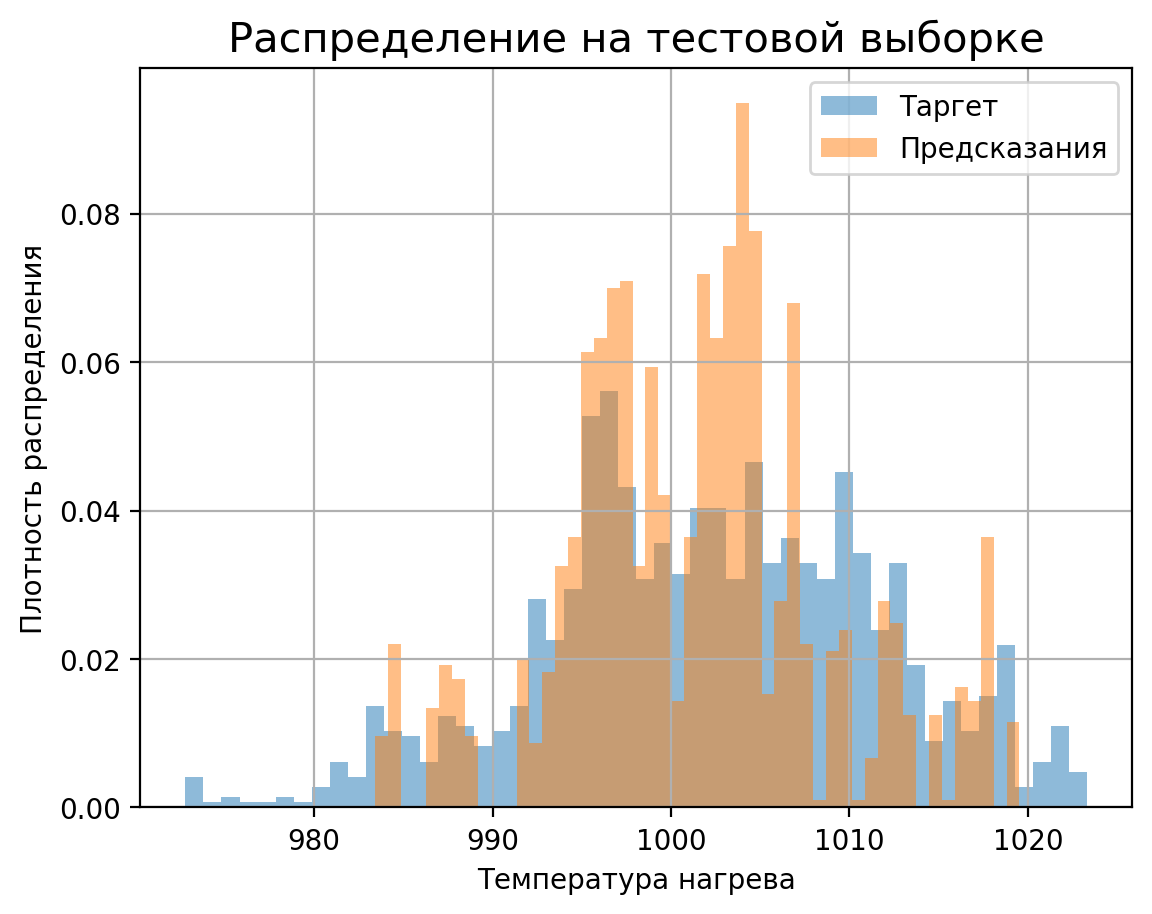

In [171]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(target_test.mean(),2),'blue')+bold(),"VS predictions",
      colored(round(predictions_test.mean() ,2),'blue'),bold_end())

target_test.hist(bins = 50, alpha=0.5, density=True)
pd.Series(predictions_test).hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

Средние похожи. Распределения также, однако предсказание ожидаемо хуже определяет крайние случаи

In [172]:
#Сравнимc дамми
dummy_model = DummyRegressor(strategy='median')

predictions_dummy, dummy_model, info_final_test = put_in_base_test(dummy_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

In [173]:
display(info_final_test)

,time_train,time_predict,MAE
GradientBoostingRegressor,1.95,0.01,5.94
DummyRegressor,0.00,0.00,7.87


Наша модель показывает себя гораздно лучше чем Дамми

## Вывод.
<a name="15."></a>
[<font size="2">(к содержанию)</font>](#1common.)

**На основе исторических данных, была построена модель для предсказания финальной температуру стали с целью оптимизировать производственные расходы, металлургического комбината и уменьшить потребление электроэнергии на этапе обработки стали.**

**Заказчику необходима модель с показателем MAE не более 8.7:**
* Полученная модель имеет на тестовой выборке МАЕ 5.43 

По результатам первичного анализа и в работу взяты:
* Кейсы содержащие минимум 2 замера температуры (первичный и окончательный).
* Кейсы с последним замером температуры после окончания нагревания дугой.

**Модель построена на основе данных о партиях на производстве*:**

* 'start_temp' - первичное измерение температуры
* 'full_time' - сколько прошло от начала первого нагревания дугой до окончания последнего
* 'count' - количество нагреваний дугой
* 'sum_arc_heating_seconds' - суммарное время нагрева дугой
* 'mean_reactive_power' - средняя реактивная мощность в процессе нагревания(в партии)
* 'ratio_active_to_reactive' - средняя соотношение активной и реактивной мощности в процессе нагревания (в партии)
* информация об объеме различных добавлений в процессе легиризации ('bulk 1','bulk 2', 'bulk 3', 'bulk 4', 'bulk 5', 'bulk 6', 'bulk 7', 'bulk 9','bulk 10', 'bulk 11', 'bulk 12', 'bulk 14', 'bulk 15', 'wire 1','wire 2', 'wire 3', 'wire 4', 'wire 6', 'wire 7', 'wire 8', 'wire 9')
* информация об объеме газа использующегося в процессе ('gaz')

***Целевой признак - Финальная температура(end_temp)***

**Модель построена с помощью CatBoostRegressor(random_state = 123):**